In [1]:
import pandas as pd
import numpy as np
import modules
from scipy import signal
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from os.path import join, exists
from os import makedirs
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fftpack
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from sklearn.preprocessing import scale
import random
import librosa
from scipy import stats
from scipy.signal import hilbert, chirp
import peakutils
import plotly
plotly.tools.set_credentials_file(username='ashafi', api_key='PxONlbVA45fzeK3YWWb9')
from plotly.offline import iplot, init_notebook_mode
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import peakutils
import plotly.graph_objs as go
import matplotlib.pyplot as plt

/Users/alia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
subj = 'UI399'
root_dir = '/Users/alia/Documents/mandarin'

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from os.path import join, exists
from os import makedirs
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fftpack
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from sklearn.preprocessing import scale
import random
import librosa
from scipy import stats

import plotly
plotly.tools.set_credentials_file(username='ashafi', api_key='PxONlbVA45fzeK3YWWb9')
from plotly.offline import iplot, init_notebook_mode
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import peakutils
import plotly.graph_objs as go
import sklearn

In [4]:
# Create directories
fdir = root_dir + '/mandarin_ffr/fig/' + subj
odir = root_dir + '/output/' + subj

if not exists(fdir):
    makedirs(fdir)
if not exists(odir):
    makedirs(odir)

## Get Mandarin Tones

In [5]:
# Where are the data?
dir_data = ''.join([root_dir, '/', subj, '/data'])
file_ECoG = ''.join([dir_data, '/', subj, '_dat_FFR_noCAR_notch_hp_allTrials.mat'])
# file_ECoG = ''.join([dir_data, '/', subj, '_dat_FFR.mat'])

# Load the .mat file
f = h5py.File(file_ECoG, 'r')

# Read ECoG data
hg_stim = np.array(f['dat']['hg_stim']) # trial * tp * ch
badChans = f['dat']['badChans'].value.flatten() - 1 # Correct for 0-indexing
time_axis = (np.round(f['dat']['time_axis'].value.flatten(), 3) * 1000).astype(int) # Use int b/c float precision


# Import behav
list_col = ['accuracy', 'block', 'choice', 'rt', 'speaker', 'syllable', 'tone', 'trial']
behav = pd.DataFrame(columns = list_col)
for icol in list_col:
    if np.in1d(icol, ['speaker', 'syllable']):
        for i in range(0, behav.shape[0]):
            behav.loc[i, icol] = ''.join(map(chr, f[f['dat']['behav'][icol][0,i]]))
    else:
        behav[icol] = np.array(f['dat']['behav'][icol]).flatten()
        
for icol in ['accuracy', 'block', 'choice', 'tone', 'trial']:
    behav[icol] = behav[icol].astype(int)
    
f.close()

#extract data from 0-500 ms 


# Get rid of NaN trials, if any
if np.in1d(subj, ['EC157','EC159', 'UI399']):
    nanTrial = np.unique(np.where(np.isnan(hg_stim))[0])
    if nanTrial.shape[0] > 0: # perform only if NaN trials exist at all
        hg_stim = np.delete(hg_stim, nanTrial, 0)
        behav = behav.drop(nanTrial, axis = 0).reset_index(drop = True)

# What are the "good" channels?
good_ch_vector = np.ones((hg_stim.shape[2])).astype(int)
good_ch_vector[badChans] = 0
goodChans = np.where(good_ch_vector)[0]
    
# Create index for behav (not literally the trial)
behav['Trial'] = range(0, behav.shape[0])

# Add the "file" column
behav['file'] = behav['syllable'].astype(str) + behav['tone'].astype(str) + '-' + behav['speaker'].astype(str) + 'N'

In [40]:
hg_stim.shape

(1661, 1501, 256)

## Read in stim

In [6]:
'''this reads each wav file, zero pads it to match the FFR, runs autocorr on all stimuli and then 
    normalizing from -1 to 1'''
import scipy.io
import os

'''autocorr the stimulation wav files t = tone, p = b or h, male or female'''
dirs = os.listdir('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/')
dataStim = pd.DataFrame()
positive = np.zeros((558,))
negative = np.zeros((500,))


for i in dirs:
    y, sr= librosa.load('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/' + i, sr = 1000)
#     y = np.append(y,positive)
#     y = np.insert(y,0,negative)
    dataStim[i] = y

## helper function

In [ ]:
import pandas as pd
import itertools
import matplotlib as pyplot

def get_FFR(e,d):
    '''takes elec and gets FFR data for ever stim assuming a 'd' ms delay'''
    dataFFR = pd.DataFrame()
    test = np.where((behav['block'] <22))[0]

    for f in test:
        file = behav['file'][f]
        myhg = hg_stim[f, :, e] ## for only electrode 15
        dataFFR[file + '_' + str(f)] = myhg[500+d:942+d] ###Assuming a 'd' ms delay

    return dataFFR

In [ ]:
def get_crosscorr_all(data):
    '''takes in data - a given FFR data - and runs cross correlation for all stim'''
    cors53 = pd.DataFrame()##because each stim was a different length
    cors11 = pd.DataFrame()
    cors58 = pd.DataFrame()
    cors3 = pd.DataFrame()
    for s in dataStim:
        correlation = []
        for f in data:
            if s[0:6] == f[0:6]:
                ## find matching stim to FFR and run correlation
                myhg = sklearn.preprocessing.scale(data[f])
                stim = sklearn.preprocessing.scale(dataStim[s])
                cor = np.corrcoef(stim, myhg)[1,0]
                correlation.append(cor)
        flat_list = correlation
        ## put correlation values in dataframe depending on length of frame
        if len(flat_list) == 3:
            cors3[s] = flat_list
        if len(flat_list) == 11:
            cors11[s] = flat_list
        if len(flat_list) == 53:
            cors53[s] = flat_list
        if len(flat_list) == 58:
            cors58[s] = flat_list
        
    correlations = pd.concat([cors53,cors58,cors11,cors3],ignore_index=False, axis=1)
    return correlations

In [ ]:
def Spec(x):
    f,t, Sxx = signal.spectrogram(myhg[400:900], 1000, noverlap = 76, nperseg =90)
    return (f,t,Sxx)


## run 2d cross correlation to get delay and correlation for all elecs 

In [ ]:
indx = np.where(behav['file'] == 'mi3-bN')
myhg = np.mean((hg_stim[indx[0], :, e]),axis = 0)
f,t, Sxx = signal.spectrogram(myhg[500:1000], 1000, noverlap = 76, nperseg =90)
plt.pcolormesh(t,f,Sxx, vmax = np.percentile(Sxx.flatten(), 99.9))
plt.title('response')
plt.show()


f,t, Sxx = signal.spectrogram(dataStim['mi3-bN.wav'], 1000, noverlap = 76, nperseg =90)
plt.pcolormesh(t,f,Sxx, vmax = np.percentile(Sxx.flatten(), 99.9))
plt.title('stim')
plt.show()



In [ ]:
elecs = [15,16,17,119]
for e in elecs:
    for s in dataStim:
        indx = np.where(behav['file'] == s[0:6])
        myhg = np.mean(hg_stim[indx[0], :, e],axis = 0)
        myhg1 = myhg[500:1500]
        Stims = dataStim[s]
        f,t, SSxx = signal.spectrogram(Stims, 1000, noverlap = 76, nperseg =90)
        ff,ft, FSxx = signal.spectrogram(myhg1, 1000, noverlap = 76, nperseg =90)
        
        if s == 'mi3-bN.wav':
            plt.pcolormesh(ft,ff, FSxx, vmax = np.percentile(FSxx.flatten(), 99.9))
            plt.title('response' + str(e) + '_' + s)
            plt.show()
            plt.pcolormesh(t,f,SSxx, vmax = np.percentile(SSxx.flatten(), 99.9))
            plt.title(s)
            plt.show()




        
        mycross = scipy.signal.correlate2d(FSxx,SSxx, mode = 'valid')
        mylag = np.where(mycross.flatten() == max(mycross.flatten()))
        print(mylag)
        
        mylag2 = np.where(mycross == np.max(mycross))
        print(mylag2)
        
        print(mycross.flatten().shape)
        plt.plot(mycross.flatten())
        plt.title(s + '_' + str(e))
        plt.axvline(x = mylag[0], color = 'r')
        plt.show()
        
#         plt.imshow(mycross, aspect = 'auto', origin = 'lower', interpolation = 'none')
#         plt.show()



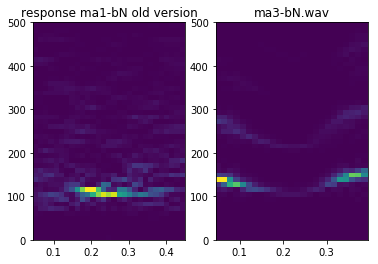

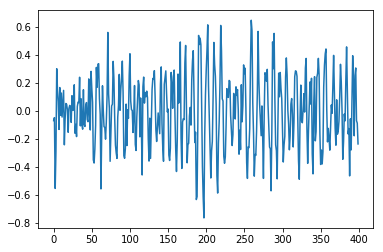

In [18]:
s = 'ma3-bN.wav'
e = 220

indx = np.where(behav['file'] == s[0:6])
myhg = np.mean(hg_stim[indx[0], :, e],axis = 0)
myhg1 = myhg
Stims = dataStim[s]
f,t, SSxx = signal.spectrogram(Stims, 1000, noverlap = 76, nperseg =90)
ff,ft, FSxx = signal.spectrogram(myhg1[500:1000], 1000, noverlap = 76, nperseg =90)

plt.subplot(1,2,1)
plt.pcolormesh(ft,ff, FSxx, vmax = np.percentile(FSxx.flatten(), 99.9))
plt.title('response ma1-bN old version')
plt.subplot(1,2,2)
plt.pcolormesh(t,f,SSxx, vmax = np.percentile(SSxx.flatten(), 99.9))
plt.title(s)
plt.show()

plt.plot(myhg[500:900])
plt.show()



# mycross = scipy.signal.correlate2d(SSxx,FSxx, mode = 'valid')
# print(mycross)
# mylag = np.where(mycross.flatten() == max(mycross.flatten()))
# print(mylag)
# print(mycross.flatten()[mylag][0])

# plt.plot(mycross.flatten())
# plt.title(s + '_' + str(e))
# # plt.axvline(x = mylag[0], color = 'r')
# plt.show()

In [39]:
def mycross(x,y):
    data = pd.DataFrame()
    cors = []
    lag = []
    for step in range(26,60):
#         print(step)
        lag.append(step)
        f,t, SSxx = signal.spectrogram(x, 1000, noverlap = 76, nperseg =90)
        ff,ft, FSxx = signal.spectrogram(y[500+step:942+step], 1000, noverlap = 76, nperseg =90)
        mycross = scipy.signal.correlate2d(SSxx,FSxx, mode = 'valid')
        cors.append(mycross[0][0])
    data['lag'] = lag
    data['cor'] = cors
    return data
    
        
    

### Run cross correlation and run a permutation

In [ ]:
#import lag ranges
delayRange = pd.DataFrame.from_csv('delay_range.csv')
test = delayRange[delayRange.elecs == 15]
test

## runs electrode and gets optimal lag for each stim

In [37]:
get_lags(15)

,lag,stim,correlations
0,24,ma2-hN.wav,0.000015
1,13,bu2-hN.wav,0.000006
2,9,ma1-bN.wav,0.000008
3,0,di4-hN.wav,0.000004
4,18,bu1-bN.wav,0.000011
5,21,ma3-bN.wav,0.000018
6,3,bu3-bN.wav,0.000020
7,27,di3-bN.wav,0.000042
8,21,bu4-hN.wav,0.000002
9,0,di1-bN.wav,0.000029


In [31]:
def get_lags(elec):
    data = pd.DataFrame()
    all_data = pd.DataFrame()
    elecs = [elec]
    for e in elecs:
        correlations = []
        stims = []
        lags = []
        elec = []
        for s in dataStim:
            indx = np.where(behav['file'] == s[0:6])
            if len(indx[0]) >= 50:
                np.random.shuffle(indx)
                myhg = np.mean(hg_stim[indx[0][0:50], :, e],axis = 0)
                cor = mycross(dataStim[s], myhg)
                lag = np.where(cor['cor'] == max(cor['cor']))
                stims.append(s)
                correlations.append(cor['cor'][lag[0][0]])
                lags.append(cor['lag'][lag[0][0]])
                elec.append(e)
            else:
                pass

        data['lag'] = lags
        data['stim'] = stims
        data['correlations'] = correlations
        
        return data
            

        
        
        
        

In [32]:
get_lags(15)

,lag,stim,correlations
0,26,ma2-hN.wav,0.000015
1,26,bu2-hN.wav,0.000006
2,26,ma1-bN.wav,0.000008
3,26,di4-hN.wav,0.000003
4,31,bu1-bN.wav,0.000011
5,26,ma3-bN.wav,0.000018
6,26,bu3-bN.wav,0.000017
7,27,di3-bN.wav,0.000042
8,26,bu4-hN.wav,0.000002
9,26,di1-bN.wav,0.000024


In [ ]:
indx = np.where(behav['file'] == 'mi3-bN')
myhg = np.mean(hg_stim[indx[0], :, 15],axis = 0)
# cor = mycross(dataStim['mi3-bN.wav'], myhg)

In [ ]:
print(cor)
# print(cor['cor'][0:100])
print(np.where(cor == max(cor['cor'][0:100])))
plt.plot(cor['cor'])
plt.title('mi3-bN elec 15')
plt.xlabel('lag = +1ms')
plt.ylabel('2dcorrelation value')
plt.show()

In [ ]:
f,t, SSxx = signal.spectrogram(dataStim['mi3-bN.wav'], 1000, noverlap = 76, nperseg =90)
ff,ft, FSxx = signal.spectrogram(a, 1000, noverlap = 76, nperseg =90)
mycross = scipy.signal.correlate2d(FSxx,SSxx, mode = 'valid')

mylag = np.where(mycross.flatten() == max(mycross.flatten()))
print(mylag)
print(mycross.flatten()[mylag][0])
plt.plot(mycross.flatten())
plt.show()

print(mycross[0][0])

## Run permutation

/Users/alia/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning:

Mean of empty slice.

/Users/alia/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning:

invalid value encountered in true_divide



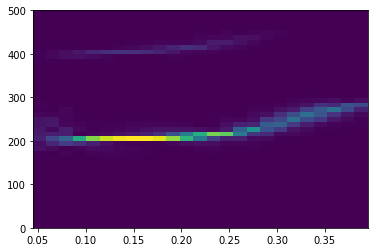

In [34]:
indx = np.where(behav['file'] == 'ma2-hN.wav')
myhg = np.mean(hg_stim[indx[0], :, 15],axis = 0)

sf,st, SSxx = signal.spectrogram(dataStim['ma2-hN.wav'], 1000, noverlap = 76, nperseg =90)
plt.pcolormesh(st,sf,SSxx, vmax = np.percentile(SSxx.flatten(), 99.9))
plt.show()


In [14]:
def run_permute(stim,response,lag, iteration):
    permutes = []
    sf,st, SSxx = signal.spectrogram(stim, 1000, noverlap = 76, nperseg =90)
    ff,ft, FSxx = signal.spectrogram(response[500+lag:942+lag], 1000, noverlap = 76, nperseg =90)
    
    plt.subplot(1,2,1)
    plt.pcolormesh(ft,ff,FSxx, vmax = np.percentile(FSxx.flatten(), 99.9))
    plt.title('response')
    plt.subplot(1,2,2)
    plt.pcolormesh(st,sf,SSxx, vmax = np.percentile(SSxx.flatten(), 99.9))
    plt.title('stim')
    plt.show()


    for i in range(iteration):
        np.random.shuffle(SSxx)
        mycross = scipy.signal.correlate2d(FSxx,SSxx, mode = 'valid')
        permutes.append(mycross[0][0])
    return permutes




    

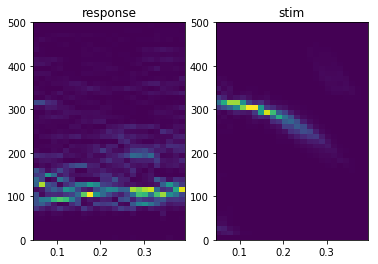

7.924383652721802e-06


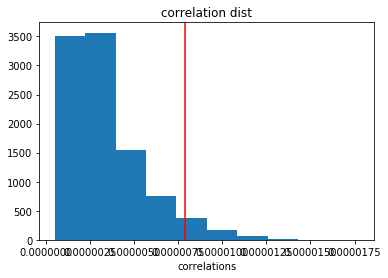

In [38]:
indx = np.where(behav['file'] == 'di4-hN')
myhg = np.mean(hg_stim[indx[0], :, 15],axis = 0)
p = run_permute(dataStim['di4-hN.wav'], myhg, 24,10000)
t = np.percentile(p,95)
print(t)
plt.hist(p)
plt.axvline(x = t, color = 'r')
plt.xlabel('correlations')
plt.title('correlation dist')
plt.show()

In [ ]:
elecs = [33,34,35,36,37,38,39,49,15,16,17,18,19,20,22,23,24,74,112,174,175,182,183,190,191,197,198,199,205,206,207,213,214,221,222,223,230,231,238,246,254]

In [19]:
PThresh[PThresh.elec == 15]

,Unnamed: 0,elec,stim,thresh,orig,pval,zscore
360,360,15,ma2-hN.wav,0.000014,0.000015,95.210479,2.190386
361,361,15,bu2-hN.wav,0.000006,0.000006,92.470753,1.576276
362,362,15,ma1-bN.wav,0.000004,0.000008,99.670033,4.767157
363,363,15,di4-hN.wav,0.000007,0.000003,51.284872,-0.239289
364,364,15,bu1-bN.wav,0.000009,0.000011,97.240276,2.781603
365,365,15,ma3-bN.wav,0.000008,0.000018,100.000000,6.244401
366,366,15,bu3-bN.wav,0.000039,0.000017,51.314869,-0.178889
367,367,15,di3-bN.wav,0.000040,0.000042,95.650435,2.022248
368,368,15,bu4-hN.wav,0.000013,0.000002,15.198480,-0.741149
369,369,15,di1-bN.wav,0.000016,0.000024,97.670233,3.400560


In [ ]:
##run permutation on all elecs and all stims
elecs = list(range(0,256))
PThresh = pd.DataFrame()
thresh = []
elec = []
stim = []
c = []
z = []
PVal = []
for e in elecs:
    data = get_lags(e)
    print(str(e) + ' is starting')
    for s in dataStim:
        indx = np.where(behav['file'] == s[0:6])
        myhg = np.mean(hg_stim[indx[0], :, e],axis = 0)
        for d in range(len(data)):
            if data['stim'][d] == s:
                stim.append(s)
                lag = data['lag'][d]
                cors = data['correlations'][d]
                p = run_permute(dataStim[s], myhg, lag,10000)
                
                t = np.percentile(p,95)
                
                p.append(cors)
                zscore = scipy.stats.zscore(p)
                pval = scipy.stats.percentileofscore(p,cors)
                
                PVal.append(pval)
                z.append(zscore[-1])
                
                
                elec.append(e)
        
        
                thresh.append(t)
                c.append(cors)
        
        
        
    

In [ ]:
homeDir = ('/Users/alia/Documents/mandarin/patientDem.csv')
P = pd.read_csv(homeDir,index_col=None, header=0, encoding = "ISO-8859-1")

In [ ]:
PThresh['elec'] = elec
PThresh['stim'] = stim
PThresh['thresh'] = thresh
PThresh['orig'] = c
PThresh['pval'] = PVal
PThresh['zscore'] = z

In [ ]:
PThresh.to_csv('zscores_data.csv')


In [7]:
scores = ('/Users/alia/Documents/mandarin/zscores_data.csv')

In [8]:
PThresh = pd.read_csv(scores,index_col=None, header=0, encoding = "ISO-8859-1")

In [ ]:
## get rid of nonsig elecs 
for i in range(len(data)):
    if data['pval'][i] < 0.05:
        data['zscore'][i] = 'NaN'

In [ ]:
## get rid of nonsig elecs 
for i in range(len(PThresh)):
    if PThresh['pval'][i] < bon:
        PThresh['zscore'][i] = 'NaN'

In [ ]:
n = PThresh[PThresh.elec == 20]
plt.scatter(n['zscore'], n['pval'])
plt.xlabel('zscore')
plt.ylabel('pval')
plt.show()

In [ ]:
bon = (100- (5/len(elecs)/ len(t)))

In [9]:
data = pd.DataFrame()
data['elec'] = PThresh['elec']
data['stim'] = PThresh['stim']
data['zscore'] = PThresh['zscore']

# d = []
# new = [d.append((100-a)/100) for a in PThresh['pval']]
# data['pval'] = new

In [ ]:
d = []
new = [d.append((100-a)/100) for a in PThresh['pval']]
data['pval'] = new

In [ ]:
from statsmodels.stats.multitest import fdrcorrection
is_significant, new_p_values = fdrcorrection(d, alpha = 0.05)
new_p_values = new_p_values.reshape(data['pval'].shape)

data['pval'] = new_p_values.tolist()

In [10]:
data =data.pivot_table(index=['stim'],columns=['elec'],values='zscore')

In [ ]:
t = np.unique(stim)
tone1 = []
tone2 = []
tone3 = []
tone4 = []
for s in flat_list:
    if '1' in s:
        tone1.append(s)

    if '2' in s:
        tone2.append(s)

    if '3' in s:
        tone3.append(s)

    if '4' in s:
        tone4.append(s)
            
for s in t:
    if '1' in s:
        tone1.append(s)

    if '2' in s:
        tone2.append(s)

    if '3' in s:
        tone3.append(s)

    if '4' in s:
        tone4.append(s)




In [11]:
t = np.unique(PThresh['stim'])
tone1h = []
tone2h = []
tone3h = []
tone4h = []
tone1b = []
tone2b = []
tone3b = []
tone4b = []
for s in t:
    if 'b' in s[3:6]:
        if '1' in s:
            tone1b.append(s)

        if '2' in s:
            tone2b.append(s)

        if '3' in s:
            tone3b.append(s)

        if '4' in s:
            tone4b.append(s)
    if 'h' in s[3:6]:
        if '1' in s:
            tone1h.append(s)

        if '2' in s:
            tone2h.append(s)

        if '3' in s:
            tone3h.append(s)

        if '4' in s:
            tone4h.append(s)


In [12]:
## new index to order in tones
ls = [tone1b,tone2b,tone3b,tone4b,tone1h,tone2h,tone3h,tone4h]
flat_list = [item for sublist in ls for item in sublist]
data = data.reindex(flat_list)

In [ ]:
data

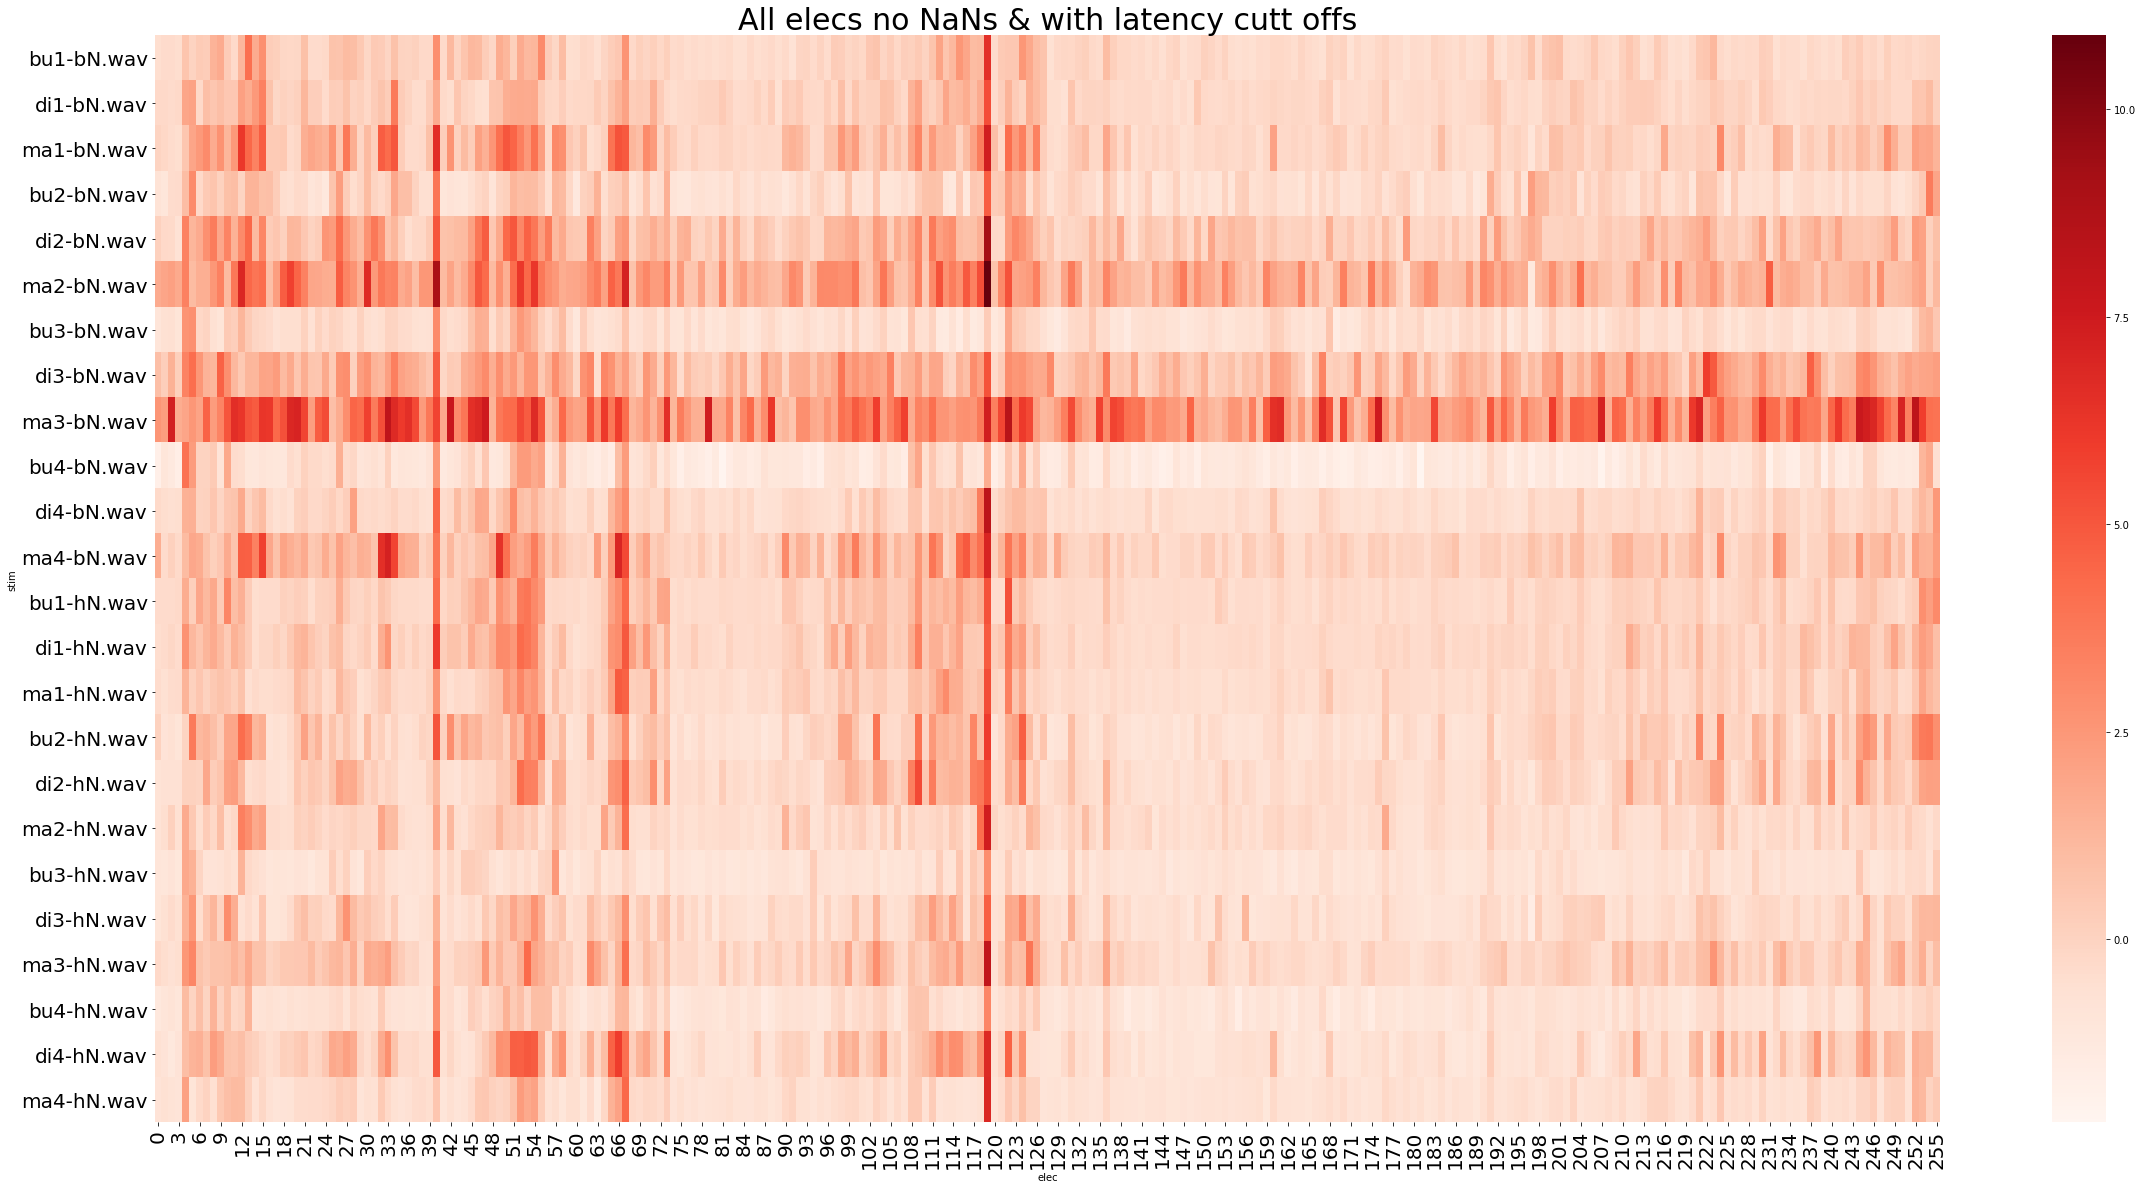

In [13]:
import seaborn
figure = plt.figure(figsize = (40,20))
plt.xticks(size = 20)
plt.yticks(size = 20)
seaborn.heatmap(data, cmap = 'Reds')
plt.title('All elecs no NaNs & with latency cutt offs', size = 30)
plt.show()

In [ ]:
plt.scatter(PThresh['orig']*1000, PThresh['zscore'])
plt.show()

In [ ]:
sf,st, SSxx = signal.spectrogram(dataStim['ma2-aN.wav'], 1000, noverlap = 76, nperseg =90)
plt.pcolormesh(st,sf,SSxx, vmax = np.percentile(SSxx.flatten(), 99.9))

In [ ]:
sig_vals = np.where(PThresh['thresh'] <= PThresh['orig'])

In [ ]:
sig_elec = []
sig_stim= []
sig = []
for i in sig_vals[0]:
    sig_elec.append(PThresh['elec'][i])
    sig_stim.append(PThresh['stim'][i])
    sig.append(PThresh['orig'][i])
    
    

In [ ]:
sigs = pd.DataFrame()
sigs['elec'] = sig_elec
sigs['stim'] = sig_stim
sigs['cor'] = sig


In [ ]:

t = sigs[sigs.elec == 15]
plt.scatter(t['stim'],t['cor']*1000)
plt.xticks(rotation = 90)
plt.show()
s = sigs[sigs.elec == 119]
plt.scatter(s['stim'],s['cor']*1000)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
plt.scatter(sigs['stim'],sigs['cor']*1000, color = 'k')
plt.scatter(sigs['stim'][0:9],sigs['cor'][0:9]*1000, color = 'r')
plt.scatter(sigs['stim'][18:40],sigs['cor'][18:40]*1000, color= 'b')
# plt.legend(loc='upper left')
plt.xticks(rotation = 90)
plt.show()

In [ ]:
col = np.where(sigs['elec']== 119)

In [ ]:
col

In [ ]:
sigs['elec'][0:9]

In [ ]:
plt.scatter(1,2)

In [ ]:
plt.show()

In [ ]:
sigs